# Multi-Head attention

1. Visualization of attention matrices $Q\cdot K^T$
2. Analysis of matrix symmetry

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Multi-head Attention Matrices


$$ Q\cdot K^T = X\,(W_Q \cdot W_K^T)\,X^T$$
Here we search for a possible mathematical interpretation of the linear transformations involved in the computation of $Q, K, V$ in multi-head attention. Specifically, we want to answer the following questions:


In single head attention:

- how different is the matrix $W_Q \cdot W_K^T$ from the identity matrix? If we find a significative difference, it means that the attention is doing something more than $X\cdot X^T$ - i.e. the projection of the buffer on itself;

- is $W_Q \cdot W_K^T$ symmetric? In that case, the attention weights can be seen as $X' \cdot X'^T$ where $X' = A\cdot X$.

In [3]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer

# Load pretrained model
model = GPT2LMHeadModel.from_pretrained('gpt2')
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
state_dict = model.state_dict()

/Users/miriamzara/LCP_B_GPT2/my_venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Attention matrices


1 - Transformation to queries, keys, values. Matrices are stacked together horizontally (column- wise). This way, only 1 matrix multiplication is required instead of 3.
$$
\begin{align}
    [Q, K, V] &= X \cdot [W_Q, W_K, W_V] + 
    \begin{pmatrix}
        \text{bias QKV} \\
        \cdots \\
        \text{bias QKV}
    \end{pmatrix} \\
    (N \cdot 3D) &= (N \cdot D) \cdot (D \cdot 3D) + (N \cdot 3D)
\end{align}
$$
2 - Splitting into heads:

$ \begin{align}
    Q &\rightarrow [Q_1, \cdots, Q_{n_H}] \\
    (N \cdot D) &=  \text{list of}\,\, (N \cdot d_K)  \\
\end{align}
$

3 - Attention computation:
$ \begin{align}
    \text{head h} &= \text{softmax}\left( \frac{Q_h\cdot K_h^T}{\sqrt{d_K} } \right) [Q_1, \cdots, Q_{n_H}] \\
    (N \cdot D) &=  \text{list of}\,\, (N \cdot d_K)  
\end{align}
$

4 - Backwards projection

$
\begin{align}
Y_{out} &= [\vec{1}, \mathbf{Y}_\text{head 1},\, \mathbf{Y}_\text{head 2} \cdots, \mathbf{Y}_\text{head nH}] \cdot
    \begin{pmatrix}
        \text{bias}_0 \\
        \mathbf{W}_0 \\
    \end{pmatrix} \\
   { \footnotesize (N \times D )} &= { \footnotesize (N\, \times\, D+ 1) \cdot (D+ 1 \, \times \, D)}\\
\end{align}
$

$$


\vec{y}_i =\sum_{j=1}^{N}\,\, A_{i,\,j}\,\vec{v}_j \longrightarrow \mathbf{Y} = \mathbf{A}\cdot \mathbf{V}

$$


$$
A_{i,\,j} = \frac{\exp \left(\frac{\langle \vec{q}_i,\, \vec{k}_j\rangle}{d_h}\right)}{\mathcal{N}_i } = \frac{\exp\left(\frac{[\mathbf{Q}\,\mathbf{K}^T]_{i,\,j}}{d_h}\right)}{\mathcal{N}_i }
$$

$$
\mathcal{N}_i =\sum_{l=1}^{N} \, \exp \left(\frac{[\mathbf{Q}\,\mathbf{K}^T]_{i,\,l}}{d_h}\right)  \longrightarrow \sum_{j=1}^{N}\, A_{i,\,j} = 1 \quad \forall\,\, i
$$

$$
A_{i,\,j} \sim \langle \vec{q}_i,\, \vec{k}_j \rangle
$$

In [4]:
layer_max = 12
qkv_weights = [state_dict[f"transformer.h.{i}.attn.c_attn.weight"].cpu().detach().numpy() for i in range(0, layer_max)] # list of N x (3D) matrices
qkv_biases = [state_dict[f"transformer.h.{i}.attn.c_attn.bias"].cpu().detach().numpy() for i in range(0, layer_max)] # list of D x 1 vectors
projection_weights = [state_dict[f"transformer.h.{i}.attn.c_proj.weight"].cpu().detach().numpy() for i in range(0, layer_max)] # list of D x D matrices
projection_biases = [state_dict[f"transformer.h.{i}.attn.c_proj.bias"].cpu().detach().numpy() for i in range(0, layer_max)] # list of D x 1 vectors
print(qkv_weights[0].shape)
print(qkv_biases[0].shape)
print(projection_weights[0].shape)
print(projection_biases[0].shape)

(768, 2304)
(2304,)
(768, 768)
(768,)


In [5]:
from numpy.linalg import norm
D = 768
num_heads = 12
d_head = D // num_heads  # = 64
layer_max = 12  # number of transformer layers

Wq = [qkv_weights[i][:, 0:D]       for i in range(layer_max)]      # shape (D, D)
Wk = [qkv_weights[i][:, D:2*D]     for i in range(layer_max)]      # shape (D, D)
Wv = [qkv_weights[i][:, 2*D:3*D]   for i in range(layer_max)]      # shape (D, D)
W0 = projection_weights

Wq_head = np.array([[w[:, head_idx*d_head:(head_idx+1)*d_head] for head_idx in range(num_heads)] for w in Wq])
Wk_head = np.array([[k[:, head_idx*d_head:(head_idx+1)*d_head] for head_idx in range(num_heads)] for k in Wk])
Wv_head = np.array([[v[:, head_idx*d_head:(head_idx+1)*d_head] for head_idx in range(num_heads)] for v in Wv])



assert Wq_head.shape == (layer_max, num_heads, D, d_head)  # (12, 12, 768, 64)



M_head = np.array([
    [np.matmul(Wq_head[layer, head], Wk_head[layer, head].T) for head in range(num_heads)]
    for layer in range(layer_max)
])



# norm of M_h itself
M_norm = norm(M_head, axis = (2, 3))
M_norm.shape # (num layers, num heads)


# || M_h - 1_D ||
I = np.eye(D)
dist_id = norm(M_head - I[None, None, :, :], axis=(2, 3))

# Need transpose over last two axes
M_T = np.transpose(M_head, axes=(0, 1, 3, 2))  # (layers, heads, D, D)
dist_T = norm(M_head - M_T, axis=(2, 3))

# scaled

dist_id_scaled = dist_id / (norm(I) + M_norm + dist_id)  # scalar + array + array
dist_T_scaled = dist_T / (2 * M_norm + dist_T)

### Checking the normalized distance across heads and layers.


$$
d(A, B) = \frac{||A-B||}{||A|| + ||B|| + ||A-B||}
$$

is a metric on the space of square matrices, with || . || indicating the Frobenius norm.

It is also normalized to the size of A and B, thus giving a measure of the relative dissimilarity of A and B, relative to their sizes.

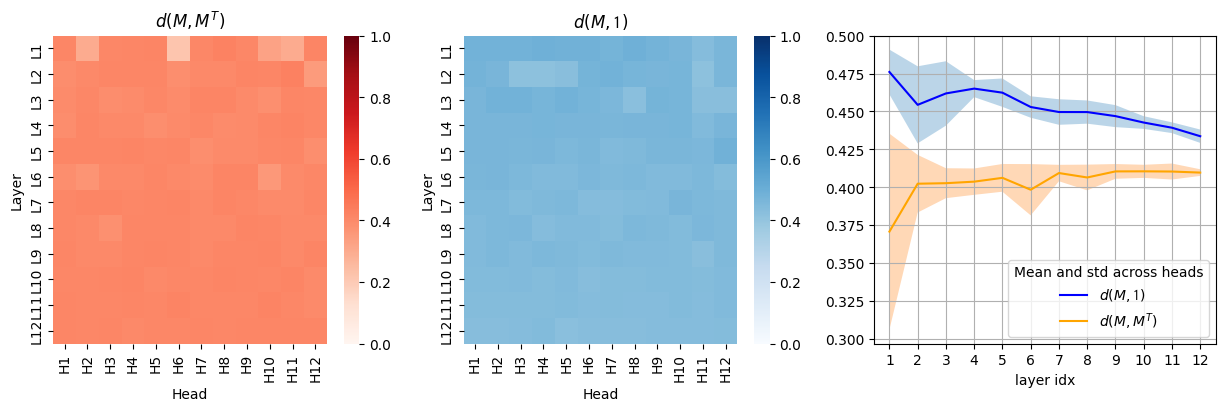

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set aesthetic

fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (15, 4))

def plot_heatmap(data, ax, title, cmap="viridis"):
    sns.heatmap(data,ax = ax, annot=False, cmap=cmap, cbar=True,
                     xticklabels=[f"H{h+1}" for h in range(num_heads)],
                     yticklabels=[f"L{l+1}" for l in range(layer_max)], vmin = 0, vmax = 1)
    ax.set_xlabel("Head")
    ax.set_ylabel("Layer")
    ax.set_title(title)

# Visualizations
plot_heatmap(dist_T_scaled, axs[0], r"$d(M,M^T)$", cmap="Reds")
plot_heatmap(dist_id_scaled, axs[1], r"$d(M, \mathcal{1})$", cmap="Blues")



mean = np.mean(dist_id_scaled, axis = 1)
std = np.std(dist_id_scaled, axis = 1)
axs[2].plot(1 + np.arange(0, layer_max ), mean, color= "blue", label = r"$ d(M, \mathcal{1})$")
axs[2].fill_between(1+np.arange(0, layer_max ), y1 = mean - std, alpha = 0.3, y2 = mean + std)


mean = np.mean(dist_T_scaled, axis = 1)
std = np.std(dist_T_scaled, axis = 1)
axs[2].plot(1 + np.arange(0, layer_max ), mean, color = "orange", label = r"$ d(M, M^T)$")
axs[2].fill_between(1+ np.arange(0, layer_max), y1 = mean - std, alpha = 0.3, y2 = mean + std)

axs[2].set_xlabel("layer idx")
axs[2].set_xticks(np.arange(1, 13))
axs[2].legend(title = "Mean and std across heads")
axs[2].grid()
plt.savefig("../miriam/attention_symm_for_slides.png",dpi = 300)

### Visualization of absolute norms of the W matrices, layer per layer


The complete W-s are doing a change of basis in R^D. Then, the splitting in heads takes projections over subspaces of dim <= d_h.

So lets look at this change of basis.

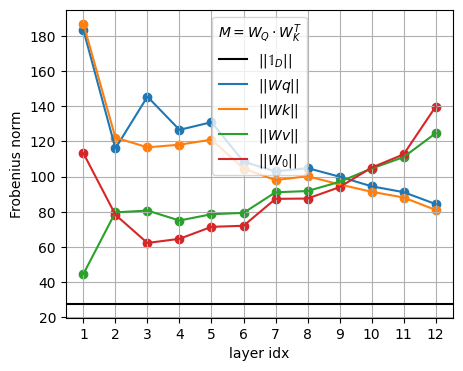

In [7]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (5,4))
plt.subplots_adjust(hspace = 0.3)


ax.axhline(y = norm(np.eye(D)), color = "black", label = r"$||\mathbb{1}_D||$")


ax.plot(np.arange(1, layer_max + 1), [norm(w) for w in Wq] , label = r"$||Wq||$")
ax.scatter(np.arange(1, layer_max + 1), [norm(w) for w in Wq])

ax.plot(np.arange(1, layer_max + 1), [norm(w) for w in Wk], label = r"$||Wk||$")
ax.scatter(np.arange(1, layer_max + 1), [norm(w) for w in Wk])

ax.plot(np.arange(1, layer_max + 1), [norm(w) for w in Wv], label = r"$||Wv||$")
ax.scatter(np.arange(1, layer_max + 1), [norm(w) for w in Wv])

ax.plot(np.arange(1, layer_max + 1), [norm(w) for w in W0], label = r"$||W_0||$")
ax.scatter(np.arange(1, layer_max + 1), [norm(w) for w in W0])

#ax.plot(np.arange(1, layer_max + 1), [norm(w @ Wv[i]) for i, w in enumerate(W0)], label = r"$||W_0 \cdot W_V||$")
#ax.scatter(np.arange(1, layer_max + 1), [norm(w @ Wv[i]) for i, w in enumerate(W0)])


ax.grid()
ax.set_xlabel("layer idx")
ax.set_ylabel("Frobenius norm")
ax.set_xticks(np.arange(1, 13))
ax.legend(title = r"$M = W_Q\cdot W_K^T$")

### How different are $W_V$ and $W_0$ ?

- Is $W_0$ (more or less) the inverse of $W_V$?
- How large is the bias term, in both terms? Why there is one?

In [8]:
from numpy.linalg import norm
D = 768
num_heads = 12
d_head = D // num_heads  # = 64
layer_max = 12  # number of transformer layers


Wv = [qkv_weights[i][:, 2*D:3*D]   for i in range(layer_max)]      # shape (D, D)
W0 = [projection_weights[i] for i in range(layer_max)]

#composed = np.array([
 #   [np.matmul(Wv_head[layer, head], W0_head[layer, head]) for head in range(num_heads)] for layer in range(layer_max) ])




#dist_v0 = [norm(wv - W0[i])/ (norm(wv) + norm(W0[i]) + norm(wv-W0[i]) ) for i, wv in enumerate(Wv)]
#dist_composed = [[norm(composed[layer, head] - np.eye(d_head))/ (norm(composed[layer, head]) + norm(np.eye(d_head)) + norm(composed[layer, head]-np.eye(d_head)) ) for head in range(num_heads)] for layer in range(layer_max)]

#fig, ax = plt.subplots()
#plot_heatmap(dist_composed, ax, r"$d(M, \mathcal{1})$", cmap="Blues")



#ax.plot(range(layer_max), [norm(v-w0bias[i])/(norm(v) + norm(w0bias[i]) + norm(v- w0bias[i])) for i, v in enumerate(vbias)])

#ax.plot(range(layer_max), [norm(v) for v in qbias])
#ax.plot(range(layer_max), [norm(v) for v in kbias])
#ax.plot(range(layer_max), [norm(v) for v in vbias])
#ax.plot(range(layer_max), [norm(v) for v in w0bias])


### 3. Computing ranks of the transformation matrices.

$W_Q, W_K, W_V, W_0$ : are they projections or change of basis?


Do they preserve distances? Do they preserve angles?

In [9]:
import numpy as np

q_rank = [np.linalg.matrix_rank(q) for q in Wq]
k_rank = [np.linalg.matrix_rank(k) for k in Wk]
v_rank = [np.linalg.matrix_rank(v) for v in Wv]
w0_rank = [np.linalg.matrix_rank(w0) for w0 in W0]

# Understanding how non symmetric matrices act on R^D

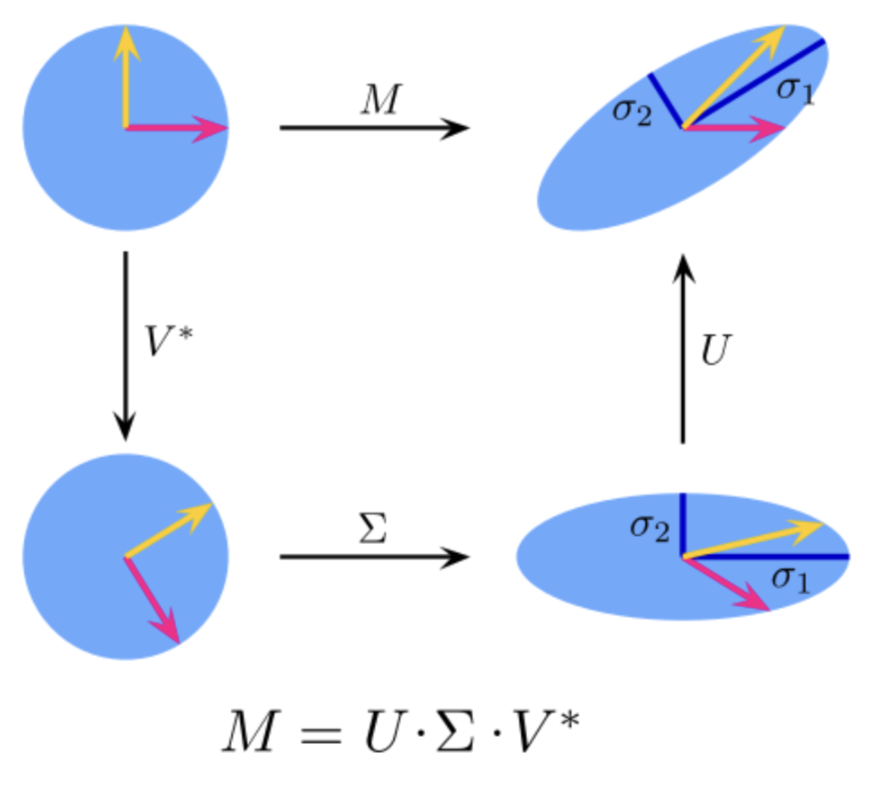

In [10]:
from IPython.display import Image
Image("../Appunti e slides/svd.png", width = 600, height= 600)

I want to understand two things now:

1. How many directions are expanded and how many are compressed, i.e. what is the effective dimensionality of the subspace resulting after the transformation
2. What is the maximum and minimum scaling factor.


I need to look at the eigenvalues of $\Sigma$ only. I will plot them (they are real) and check the spectrum.



$$
\Sigma = \begin{pmatrix}
\sigma_1 & 0        & \cdots & 0 \\
0        & \sigma_2 & \cdots & 0 \\
\vdots   & \vdots   & \ddots & \vdots \\
0        & 0        & \cdots & \sigma_D
\end{pmatrix}
$$


**Careful**  Since $Q = W_Q\cdot X$, and similarly for the others, the linear transformation to consider is $\vec{y} = W_Q^T\cdot \vec{x}$.

But anyway, as long as we are interested in the singular values only, it makes no difference if we consider $W$ or $W^T$, since

$$
W^T =(U\cdot \Sigma \cdot V^T)^T = V \Sigma U^T
$$

In [11]:
import numpy as np
from scipy.linalg import svd

# Wq, Wk, Wv, W0 list of (D, D) arrays
D = 768
num_heads = 12
d_head = D // num_heads  # = 64
layer_max = 12  # number of transformer layers

Wqt = [qkv_weights[i][:, 0:D].T       for i in range(layer_max)]      # shape (D, D)
Wkt = [qkv_weights[i][:, D:2*D].T     for i in range(layer_max)]      # shape (D, D)
Wvt = [qkv_weights[i][:, 2*D:3*D].T   for i in range(layer_max)]      # shape (D, D)
W0t = [w.T for w in projection_weights]



svd_W0 = [(U, S, Vt) for (U, S, Vt) in map(svd, W0t)]
svd_Wq = [(U, S, Vt) for (U, S, Vt) in map(svd, Wqt)]
svd_Wk = [(U, S, Vt) for (U, S, Vt) in map(svd, Wkt)]
svd_Wv = [(U, S, Vt) for (U, S, Vt) in map(svd, Wvt)]

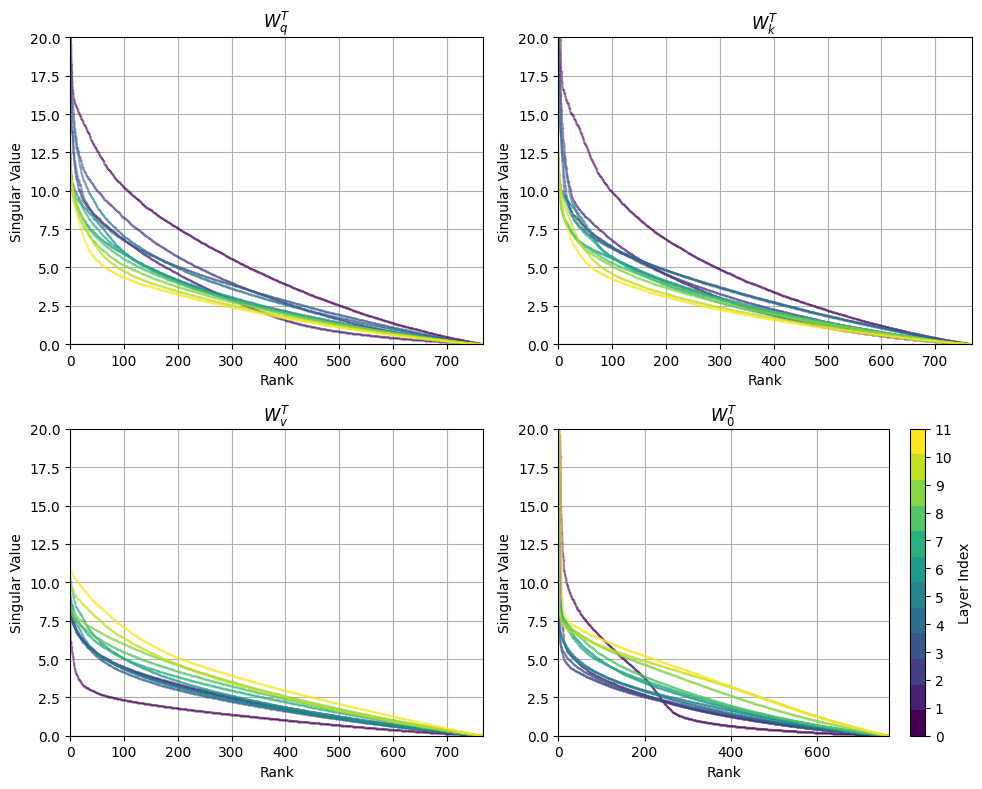

In [12]:
# Get a colormap with N discrete colors from 'viridis'
N = len(svd_W0)
cmap = plt.get_cmap('viridis', N)  # Discretized colormap

def plot_eig(svd_list, ax, title):
    for i, (_, Sigma, _) in enumerate(svd_list):
        ax.plot(Sigma, marker='o', markersize = 0.3, alpha = 0.5, label=f'Matrix {i}', color=cmap(i))
    ax.set_title('Singular Values vs. Rank')
    ax.set_xlabel('Rank')
    ax.set_ylabel('Singular Value')
    ax.set_ylim((0, 20))
    ax.set_xlim((0, D))
    ax.set_title(title)
    ax.grid(True)

# Plot 2: Distribution (histogram)

# Plotting
fig, axes = plt.subplots(2, 2, figsize=(2*5, 2*4))
axes = axes.flatten()
plot_eig(svd_Wq, axes[0], title = r"$W_q^T$")
plot_eig(svd_Wk, axes[1], title = r"$W_k^T$")
plot_eig(svd_Wv, axes[2], title = r"$W_v^T$")
plot_eig(svd_W0, axes[3], title = r"$W_0^T$")



# Create colorbar
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
norm = Normalize(vmin=0, vmax=N-1)
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Required for colorbar with ScalarMappable
cbar = plt.colorbar(sm, ax=axes[3], ticks=range(N))
cbar.set_label("Layer Index")
cbar.set_ticks(range(N))
cbar.set_ticklabels([f'{i}' for i in range(N)])


plt.tight_layout()
plt.show()

Notice that singular values decrease with layer idx for the matrices $W_Q, W_K$, while they tend to increase with layer idx for the other two, $W_V$ and $W_0$.

Also the norm of these matrices show the same trend. These things could be linked.

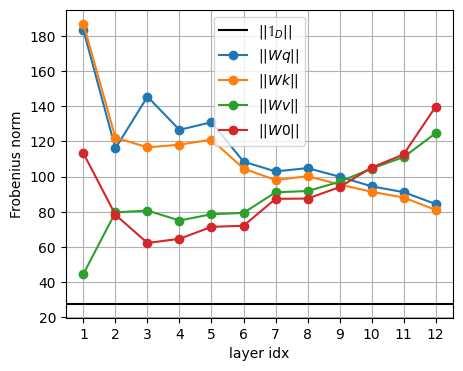

In [13]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (5,4))
plt.subplots_adjust(hspace = 0.3)


ax.axhline(y = np.linalg.norm(np.eye(D)), color = "black", label = r"$||\mathbb{1}_D||$")
ax.plot(np.arange(1, layer_max + 1), [np.linalg.norm(w) for w in Wq] ,  marker = "o", label = r"$||Wq||$")
ax.plot(np.arange(1, layer_max + 1), [np.linalg.norm(w) for w in Wk] ,  marker = "o", label = r"$||Wk||$")
ax.plot(np.arange(1, layer_max + 1), [np.linalg.norm(w) for w in Wv] ,  marker = "o", label = r"$||Wv||$")
ax.plot(np.arange(1, layer_max + 1), [np.linalg.norm(w) for w in W0] ,  marker = "o", label = r"$||W0||$")

ax.grid()
ax.set_xlabel("layer idx")
ax.set_ylabel("Frobenius norm")
ax.set_xticks(np.arange(1, 13))
ax.legend()
plt.show()

<>:21: SyntaxWarning: invalid escape sequence '\s'
<>:21: SyntaxWarning: invalid escape sequence '\s'
/var/folders/vk/kftm8379123bsmwrdp8l0xr00000gn/T/ipykernel_3257/1630845120.py:21: SyntaxWarning: invalid escape sequence '\s'
  plt.ylabel(f'Singular Value $\sigma_i$')


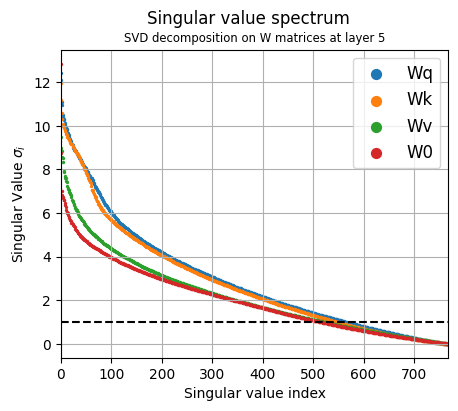

In [16]:
def plot_eigs_layer(svd_tuple,  label, every = 1):
    Sigma = svd_tuple[1]
    Sigma_sorted = np.sort(Sigma)[::-1]  # descending order
    plt.scatter(np.arange(0, D, every), Sigma_sorted[::every], alpha = 1, s = 2, label = label)

layer_idx = 5

# Plotting
fig = plt.figure(figsize = (5,4))
plt.suptitle("Singular value spectrum")
plt.title("SVD decomposition on W matrices at layer 5", fontsize = "small")

plot_eigs_layer(svd_Wq[layer_idx], "Wq")
plot_eigs_layer(svd_Wk[layer_idx], "Wk")
plot_eigs_layer(svd_Wv[layer_idx],  "Wv")
plot_eigs_layer(svd_W0[layer_idx],  "W0")


plt.axhline(y = 1, color = "black", linestyle = "dashed")
plt.xlabel('Singular value index')
plt.ylabel(f'Singular Value $\sigma_i$')
plt.xlim((0, D))

legend = plt.legend(fontsize = "large")
for handle in legend.legend_handles:
    handle.set_sizes([50])
plt.grid()
plt.savefig("../miriam/svd_W_for_slides.png", dpi = 300)


In [15]:
Sigma = np.sort(svd_Wq[layer_idx][1])[::-1]

condition_number = Sigma[0]/Sigma[-1]
#volume = np.prod(Sigma)
volume_log = np.sum(np.log(Sigma))
volume = np.exp(volume_log)
print("Volume log:", volume_log)
print("Volume:", volume)
print("Condition number:", condition_number)

# Shannon entropy (effective rank)
p = Sigma/np.sum(Sigma)
H = np.sum(p*np.log(p))
eff_rank = np.exp(-H)
print("entropy", H)
print("eff rank", eff_rank)


# Stable Rank
p = Sigma/np.sum(Sigma)
H = np.sum(p*np.log(p))
eff_rank = np.exp(-H)
print("entropy", H)
print("eff rank", eff_rank)

Volume log: 393.94125
Volume: inf
Condition number: 34819.75
entropy -6.2832427
eff rank 535.5224
entropy -6.2832427
eff rank 535.5224


/var/folders/vk/kftm8379123bsmwrdp8l0xr00000gn/T/ipykernel_3257/3674630347.py:6: RuntimeWarning: overflow encountered in exp
  volume = np.exp(volume_log)


$$

\text{Condition Number} = \frac{\sigma_{min}}{\sigma_{max}} \\

\text{Volume Scaling Factor} = \prod_{i=1}{D}\, \sigma_i \\

\text{Eff Rank} = \exp\left[- \sum_{i=1}^D\, p_i\cdot \log(p_i) \right] \quad

p_i = \frac{\sigma_i}{\sum_j\,\sigma_j}



\begin{cases}
p_i = 1/D \quad \rightarrow H = -\log(D)\quad \text{Eff. Rank}= D \\
p_1 \simeq 1, p_j \simeq 0 \rightarrow H \simeq 0 \quad \text{Eff. Rank} = 1 
\end{cases}

$$

Is it significative that all the matrices reduce R^D to a subspace of the same effective dimensionality (around 500)?


The model has learned to compress the inputs into the most useful directions—akin to unsupervised dimensionality reduction.